Guillaume Chaslot <guillaume.chaslot@data.gouv.fr>

# Tax Legislation Refactoring

The tax/benefit legislation on individuals in France is more than 200,000 lines long.

We believe that with this tool, you can make it less than 100 lines, transparent, and 95% similar to the existing legislation

### How it works:

1. Define your concepts (e.g., 'nb_enfants', 'age', 'parent isolé') and budget (e.g.: cost less than 2 millions euros)
2. The machine learning algorithm helps you adjust the parameters of your reform to approximate the current legislation and fit your budget
3. From the biggest discrepencies with the current legislation, you can improve your concepts (or the legislation)
4. Repeat until you reach a legislation that matches your own goals. The algorithm takes care of minimizing your budget and maximizing the similarity to current legislation.

### Beta version limitations:

For this test, we only take a population of people from all ages, who have 0 to 5 children, no salary, married, veuf, paces, divorces or celibataires, and simulate the "aides sociales"

### Current Results:

Within a few minutes, we got a tax reform for "aides sociales" for people with no salary that is:

* 6 lines long 
* similar to the existing in average at more than 95%


In [14]:
from utils import show_histogram, percent_diff, scatter_plot

#pip install Wand

import matplotlib.pyplot as plt
# import bqplot.pyplot as plt

import pandas as pd
import numpy as np
import random
import qgrid

from reformators import Excalibur

qgrid.nbinstall(overwrite=True)

%matplotlib inline

def show_last_reform_results():
    if cost > 0:
        display_cost_name = 'Total Cost in Euros'
        display_cost_value = int(cost)
    else:
        display_cost_name = 'Total Savings in Euros'
        display_cost_value = -int(cost)

    result_frame = pd.DataFrame({
        display_cost_name: [display_cost_value],
        'Average change / family / month in Euros' : [int(error) / 12],
        })

    result_frame.set_index(display_cost_name, inplace=True)
    qgrid.show_grid(result_frame)


# Which variable do you want to optimize?

Here, we want to optimize the variable 'revdisp' which by putting a tax on 'taxable_income'

In [15]:
reformator = Excalibur(target_variable='revdisp',
                       taxable_variable='taxable_income')

# What is the population you want to use?

The population data is simulated for now, see population_simulator.py for details.

In [16]:
reformator.load_openfisca_results('1aj-1bj-f-2000')

# # Removing unlikely cases of super old parents due to our approximative population
# reformator.filter_only_likely_population()

# # Keeping only people with no revenu for this test
# reformator.filter_only_no_revenu()

# What are the concept you want to use for your reform?

You can add concepts like the number of children, age, family situation, etc... 

The input population is in the CERFA "declaration des revenus" format.

In [17]:
def married(family):
    return 'M' in family

def pacse(family):
    return 'O' in family

def veuf(family):
    return 'V' in family

def divorce(family):
    return 'D' in family

def age_dec_1(family):
    return age_from_box(family, '0DA')

def age_dec_2(family):
    if '0DB' in family:
        return age_from_box(family, '0DB')
    return None

def if_two_people(family):
    return '0DB' in family

def revenu_1(family):
    return family['1AJ']

def revenu_2(family):
    if '1BJ' in family:
        return family['1BJ']
    return False
    
def age_from_box(family, birthdate_box):
    return 2014 - family[birthdate_box]

def if_both_declarant_parent_below_24(family):
    if age_dec_1(family) >= 24:
        return False
    if '0DB' in family and age_dec_2(family) >= 24:
        return False
    if 'F' not in family or family['F'] == 0:
        return False
    return True

def nb_enfants(family):
    if 'F' in family:
        return family['F']
    else:
        return None

def if_parent_isole(family):
    return 'F' in family and family['F'] >= 1 and ('0DB' not in family)

def if_enfant_unique(family):
    return 'F' in family and family['F'] == 1

def if_deux_enfants_ou_plus(family):
    return 'F' in family and family['F'] >= 2

def nb_enfants_after_2(family):
    if 'F' in family and family['F'] >= 2:
        return family['F'] - 2
    return None

def if_declarant_above_64(family):
    return age_from_box(family, '0DA') > 64
    
def if_codeclarant_above_64(family):
    return '0DB' in family and age_from_box(family, '0DB') > 64

def if_one_declarant_above_24(family):
    return (age_from_box(family, '0DA') >= 24 or ('0DB' in family and age_from_box(family, '0DB') >= 24))

def if_one_declarant_above_24_or_has_children(family):
    return (age_from_box(family, '0DA') >= 24 or ('0DB' in family and age_from_box(family, '0DB') >= 24) or 
           ('F' in family and family['F'] >= 1))

reformator.add_concept('age_dec_1', age_dec_1)
reformator.add_concept('age_dec_2', age_dec_2)
reformator.add_concept('revenu_1', revenu_1)
reformator.add_concept('revenu_2', revenu_2)
reformator.add_concept('nb_enfants', nb_enfants)
reformator.add_concept('nb_enfants_after_2', nb_enfants_after_2)
reformator.add_concept('if_one_declarant_above_24', if_one_declarant_above_24)
reformator.add_concept('if_one_declarant_above_24_or_has_children', if_one_declarant_above_24_or_has_children)
reformator.add_concept('if_both_declarant_parent_below_24', if_both_declarant_parent_below_24)
reformator.add_concept('if_declarant_above_64', if_declarant_above_64)
reformator.add_concept('if_codeclarant_above_64', if_codeclarant_above_64)
reformator.add_concept('if_enfant_unique', if_enfant_unique)
reformator.add_concept('if_deux_enfants_ou_plus', if_deux_enfants_ou_plus)
reformator.add_concept('if_two_people', if_two_people)
reformator.add_concept('if_parent_isole', if_parent_isole)

reformator.summarize_population()

Echantillon of 2863 people, in percent of french population for similar revenu: 0.14315%


# Plots Revenu disponible before reform

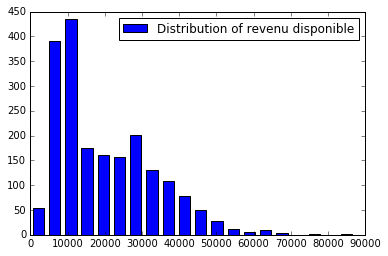

In [18]:
revdisp = list(family['revdisp'] for family in reformator._population)

show_histogram(revdisp, 'Distribution of revenu disponible')

# <font color='red'>Define your reform here!</font>


In [19]:
simulated_reform, error, cost, final_parameters  = reformator.suggest_reform(
            parameters=[
                            'age_dec_1',
                            'age_dec_2',
                            'if_enfant_unique',
                            'if_deux_enfants_ou_plus',
                       ],
                       max_cost=0,
                       min_saving=0,
#                        image_file='./enfants_age',
#                        max_depth=4,
#                        min_samples_leaf=20
                        )

['age_dec_1', 'age_dec_2', 'if_enfant_unique', 'if_deux_enfants_ou_plus']
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=368251, Fri Sep 30 16:24:26 2016)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.958282450262088e+07 1.0e+00 8.26e+03  8e+03  8e+03 0:0.0
    2     16 6.339132118397067e+07 1.1e+00 6.78e+03  6e+03  8e+03 0:0.1
    3     24 1.902596756160744e+08 1.4e+00 6.33e+03  5e+03  7e+03 0:0.1
Best solution: average change / person / month = 16618 costing a total of 17810 millions per year
Best solution: average change / person / month = 1933 costing a total of -724 millions per year
Best solution: average change / person / month = 1327 costing a total of -942 millions per year
Best solution: average change / person / month = 5517 costing a total of 1930 millions per year
Best solution: average change / person / month = 1282 costing a total of -1192 millions per year
Best solution: average change / person / month = 918 costing a to

# <font color="darkgreen">Reform results</font>

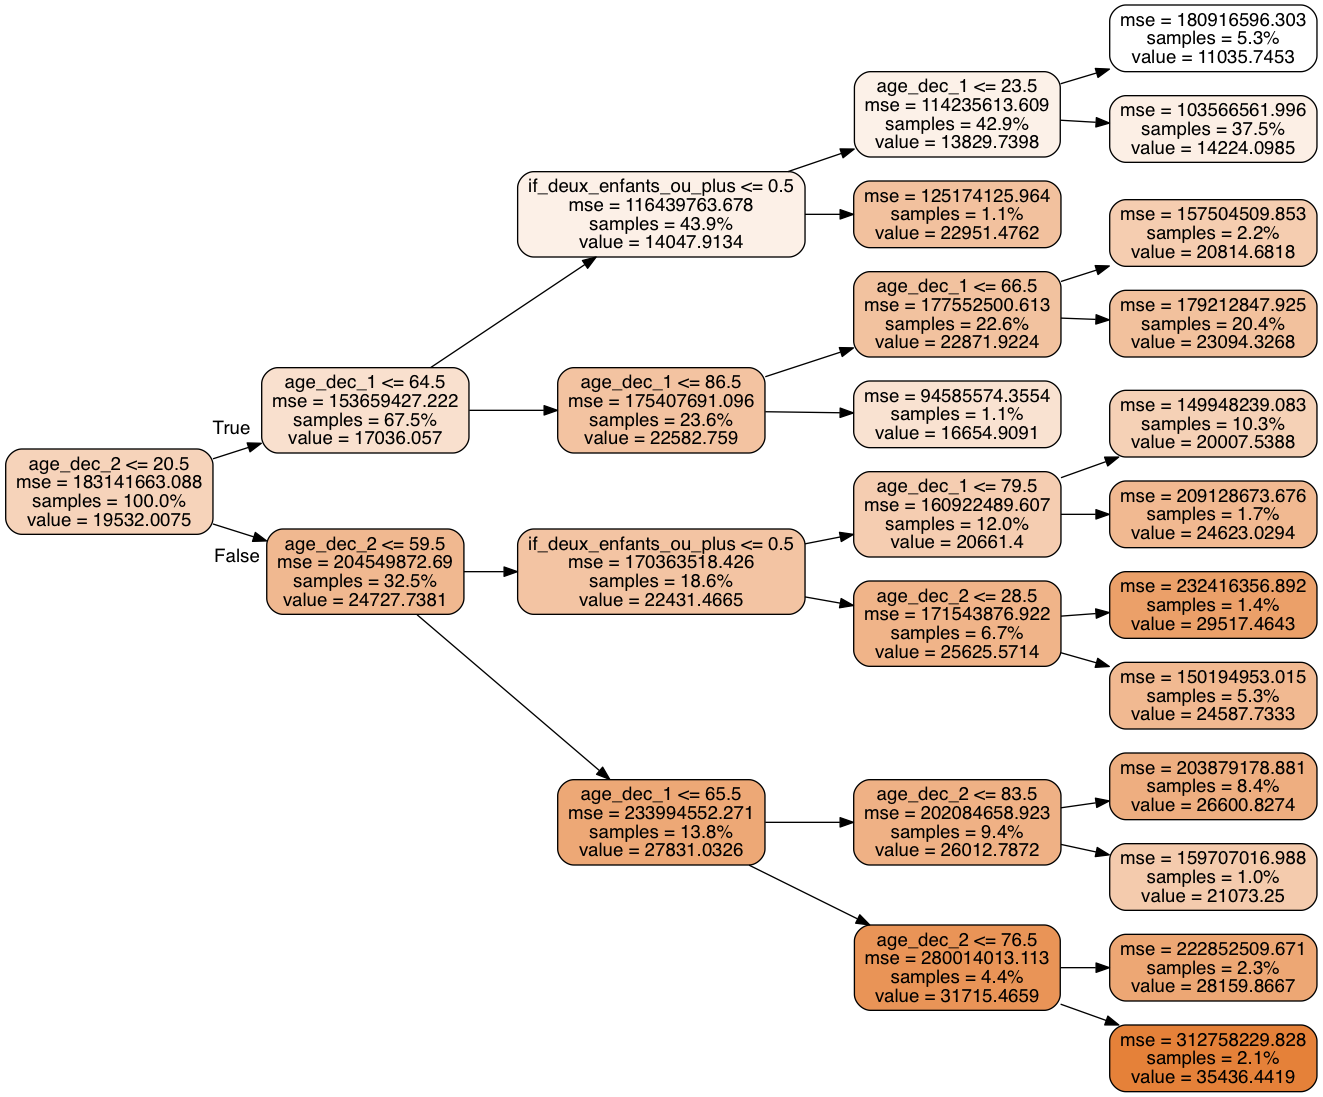

In [20]:
show_last_reform_results()
from IPython.display import Image
Image(filename='./enfants_age.png')

#  <font color="darkgreen">Reform parameters</font>

In [21]:
coefficients = list(map(lambda x: x['value'], final_parameters)); variables = list(map(lambda x: x['variable'], final_parameters))
result_frame = pd.DataFrame({'Variables': variables, 'Coefficient': coefficients})
result_frame.set_index('Variables', inplace=True)
qgrid.show_grid(result_frame)

# Plots revenu disponible after reform

In [ ]:
xmin = 0
xmax = 18000
nb_buckets = 35

bins = np.linspace(xmin, xmax, nb_buckets)

plt.hist(revdisp, bins, alpha=0.5, label='current')
plt.hist(simulated_reform, bins, alpha=0.5, label='reform')
plt.legend(loc='upper right')
plt.show()

# Distribution of the changes in revenu in euros

In [13]:
difference = list(simulated_reform[i] - revdisp[i] for i in range(len(simulated_reform)))

show_histogram(difference, 'Changes in revenu')

NameError: global name 'revdisp' is not defined

# Distribution of the change in revenu in percentage

In [ ]:
percentage_difference = list(100 * percent_diff(simulated_reform[i], revdisp_when_no_salary[i]) for i in range(len(simulated_reform)))

show_histogram(percentage_difference, 'Changes in revenu')

# Change as a function of the number of children

In [ ]:
nb_children = list((reformator._population[i].get('nb_enfants', 0)  for i in range(len(reformator._population)))) 

scatter_plot(nb_children, difference, 'Children', 'Difference reform - current', alpha=0.05)

# Change as a function of the age of declarant 1

A scatter plot is better than a thousand points #ChineseProverb

In [ ]:
age_dec1 = list((reformator._population[i].get('age_dec_1', 0)  for i in range(len(reformator._population)))) 

scatter_plot(age_dec1, difference, 'Age declarant 1', 'Difference reform - current', alpha=0.1)

# <font color="Red">Most important: Edge Cases</font>

This is the heart of this tool: by seeing the worse cases, you can discover when the current legislation is smarter than yours (or the other way), and improve it further

In [ ]:
order = sorted(range(len(simulated_reform)), key=lambda k: -abs(simulated_reform[k] - revdisp_when_no_salary[k]))

data = {}

possible_keys = set()
for i in order:
    for key in reformator._raw_population[i]:
        if key != 'year':
            possible_keys.add(key)

for i in order:
    # Adding the diff with the reform.
    differences = data.get('difference', [])
    differences.append(abs(int(simulated_reform[i] - revdisp_when_no_salary[i])))
    data['difference'] = differences

    for key in possible_keys:
        new_vals = data.get(key, [])
        value = reformator._raw_population[i].get(key, '')
        if type(value) == float:
            value = int(value)
        new_vals.append(value)
        data[key] = new_vals

    # Adding reformed line.
    reforms = data.get('reform', [])
    reforms.append(int(simulated_reform[i]))
    data['reform'] = reforms

df = pd.DataFrame(data=data)
df.set_index('difference', inplace=True)
qgrid.show_grid(df)


# Best compromise simplicity / matching current legislation:

In [ ]:
res, error, cost, final_parameters = reformator.suggest_reform(parameters=[
                            'if_one_declarant_above_24',
                            'if_declarant_above_64',
                            'if_codeclarant_above_64',
                            'if_both_declarant_parent_below_24',
                            'if_two_people',
                            'if_enfant_unique',
                            'if_deux_enfants_ou_plus',
                            'nb_enfants_after_2',
                           ])

In [ ]:
coefficients = list(map(lambda x: x['value'], final_parameters)); variables = list(map(lambda x: x['variable'], final_parameters))
result_frame = pd.DataFrame({'Variables': variables, 'Coefficient': coefficients})
result_frame.set_index('Variables', inplace=True)
qgrid.show_grid(result_frame)